In [74]:
# important imports for this notebook
from absl import logging
import flax
import jax.numpy as jnp
import jax
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

import optax
from flax.training import train_state

logging.set_verbosity(logging.INFO)

In [75]:
# Load in a dataset - start with mnist

# These commands break up the load command into it's parts for more controls
ds_builder = tfds.builder('mnist')
ds_builder.download_and_prepare()
# 60000 training samples - no shuffle, no batch causes this to return a tensor of
# all of the data instead of a tensorflow dataset structure - we won't use tf.data
# here and just want to convert to numpy - these return dictionaries
train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))

# convert to 0 - 1 range for neural network training - don't want an arbitrary weight
# which could cause large gradients and difficult training.
train_ds['image'] = jnp.float32(train_ds['image']) / 255.0
test_ds['image'] = jnp.float32(test_ds['image']) / 255.0

INFO:absl:Load dataset info from /home/don/tensorflow_datasets/mnist/3.0.1
INFO:absl:For 'mnist/3.0.1': fields info.[citation, splits, supervised_keys, module_name] differ on disk and in the code. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/home/don/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/don/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/don/tensorflow_datasets/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/don/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/don/tensorflow_datasets/mnist/3.0.1


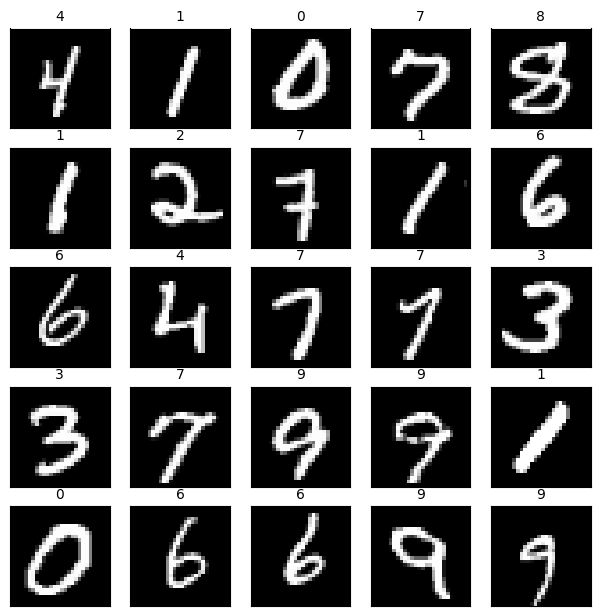

In [76]:
# Always good to check the data to make sure it loaded in properly
# Helper functions for images.

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[..., 0], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title, fontsize=10)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(1.5 * n, 1.5 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

show_img_grid(
    [train_ds['image'][idx] for idx in range(25)],
    [f'{train_ds["label"][idx]}' for idx in range(25)],
)
     

In [26]:
%load_ext tensorboard
%tensorboard --logdir='flax_runs'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 28198), started 0:07:10 ago. (Use '!kill 28198' to kill it.)

In [112]:
# set up a convolutional model for image data in flax
from flax import linen as nn

class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        # this is like the sequential model from Haiku
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.reshape((x.shape[0], -1)) #flatten the outputs
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)

        # Need 10 output logits (1 per number) - thesse are assumed
        # to be log(probabilites) and will be fed into a softmax
        # layer at evaluation time. the softmax could also be placed
        # here
        x = nn.Dense(features=10)(x)
        
        return x

In [115]:
# test the model
batch_size = 128
learning_rate = 0.001

rng = jax.random.key(0)

model = CNN()

batch = jnp.ones([1, 28, 28, 1])

rng, init_rng = jax.random.split(rng)

# initialize the model (i.e. generate random weights / parameters )
params = model.init(init_rng, batch)['params']

# params has to go in a kwarg
model.apply({'params': params}, batch).shape

(1, 10)

In [116]:
# We need a function to apply the gradients to the model, which will
# update the parameters - can be used to update the model, or we 
# can ignore the gradients and calculate stats for the test set
@jax.jit
def apply_model(state, images, labels):
    
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, images)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy

In [117]:
# simulate one training run
# initialize optax with a particular training algorithm
tx = optax.adam(learning_rate=learning_rate)

# we then store the state of the training (current parameters, state of optax, and the function to apply)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)
rng, init_rng = jax.random.split(rng)

train_ds_size = len(train_ds['image'])
# Once we have a random permutation of data, this is how many times we 
# will need ot divide it up to get the required batches
steps_per_epoch = train_ds_size // batch_size

# Get a random permutation
perms = jax.random.permutation(rng, len(train_ds['image']))
perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
perms = perms.reshape((steps_per_epoch, batch_size))

# So perms will just be a list of indcies into the original training dataset

# This is what one batch of the permutation looks like then
batch_images = train_ds['image'][perms[0], ...]
batch_labels = train_ds['label'][perms[0], ...]

# 1 - apply model - apply the model to the current batch images, get the logits,
# get the loss, and calculate the gradients over the current batch
grads, loss, accuracy = apply_model(state, batch_images, batch_labels)

# 2 - apply the gradients to update the parameters and then update the state 
# variable (it will internally keep track of the step number)
state = state.apply_gradients(grads=grads)

# 3 - now we could do it all over again

In [108]:
batch_images.shape

(128, 28, 28, 1)

In [118]:
# then we can put this into a full training loop - this is 1 epoch, i.e. 
# one full run through all of the distinct data. Generally you will need 
# to run many epochs to fully train a network though.
epoch_loss = []
epoch_accuracy = []

for perm in perms:
    batch_images = train_ds['image'][perm, ...]
    batch_labels = train_ds['label'][perm, ...]

    grads, loss, accuracy = apply_model(state, batch_images, batch_labels)

    state = state.apply_gradients(grads=grads)

    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)

train_loss = np.mean(epoch_loss)
train_accuracy = np.mean(epoch_accuracy)

logging.info(
        'epoch:% 3d, train_loss: %.4f, train_accuracy: %.2f, test_loss: %.4f,'
        ' test_accuracy: %.2f'
        % (
            1,
            train_loss,
            train_accuracy * 100,
            0,
            0 * 100,
        )
    )

INFO:absl:epoch:  1, train_loss: 489.1062, train_accuracy: 10.14, test_loss: 0.0000, test_accuracy: 0.00


In [58]:
train_accuracy

0.14324078